# File: notebooks/train_model.ipynb

## === Imports and Path Setup ===

In [1]:
# Standard libraries
import os
import sys
import pickle
import numpy as np
import pandas as pd

# ML libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score

# Deep learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Visualization
import matplotlib.pyplot as plt

# Enable access to utils/ folder
sys.path.append(os.path.abspath(".."))
from utils.preprocessing import process_subject


## === Load and Process Dataset ===

In [2]:
# Path to preprocessed data
data_path = "../data"
subject_files = [f for f in os.listdir(data_path) if f.endswith(".pkl")]

# Load all subjects and extract features
X_all, y_all = [], []

for file in subject_files:
    try:
        X, y = process_subject(os.path.join(data_path, file))
        X_all.extend(X)
        y_all.extend(y)
        print(f"Processed {file} ({len(X)} samples)")
    except KeyError as e:
        print(f"Skipping {file}: {e}")

X_all = np.array(X_all)
y_all = np.array(y_all)

print(f"\nTotal samples: {len(X_all)}")


Processed S10.pkl (10418 samples)
Processed S11.pkl (10172 samples)
Processed S13.pkl (10084 samples)
Processed S14.pkl (10144 samples)
Processed S15.pkl (10178 samples)
Processed S16.pkl (10135 samples)
Processed S17.pkl (10412 samples)
Processed S2.pkl (9619 samples)
Processed S3.pkl (9735 samples)
Processed S4.pkl (9805 samples)
Processed S5.pkl (10079 samples)
Processed S6.pkl (10008 samples)
Processed S7.pkl (9986 samples)
Processed S8.pkl (10057 samples)
Processed S9.pkl (9981 samples)

Total samples: 150813


## === Normalize and Split ===

In [3]:
# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_all)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_all, test_size=0.2, random_state=42, stratify=y_all)

print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")


Training samples: 120650
Testing samples: 30163


## === Build and Train Model ===

In [4]:
# Define neural network
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=30, batch_size=32)


Epoch 1/30
3771/3771 [==============================] - 13s 3ms/step - loss: 0.2388 - accuracy: 0.9016 - val_loss: 0.1304 - val_accuracy: 0.9524
Epoch 2/30
3771/3771 [==============================] - 10s 3ms/step - loss: 0.1404 - accuracy: 0.9480 - val_loss: 0.0891 - val_accuracy: 0.9710
Epoch 3/30
3771/3771 [==============================] - 11s 3ms/step - loss: 0.1117 - accuracy: 0.9610 - val_loss: 0.0711 - val_accuracy: 0.9769
Epoch 4/30
3771/3771 [==============================] - 13s 3ms/step - loss: 0.0910 - accuracy: 0.9692 - val_loss: 0.0548 - val_accuracy: 0.9836
Epoch 5/30
3771/3771 [==============================] - 12s 3ms/step - loss: 0.0801 - accuracy: 0.9732 - val_loss: 0.0462 - val_accuracy: 0.9860
Epoch 6/30
3771/3771 [==============================] - 11s 3ms/step - loss: 0.0721 - accuracy: 0.9768 - val_loss: 0.0433 - val_accuracy: 0.9861
Epoch 7/30
3771/3771 [==============================] - 11s 3ms/step - loss: 0.0662 - accuracy: 0.9783 - val_loss: 0.0388 - val_ac

## === Evaluate Model ===

943/943 [==============================] - 2s 2ms/step
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     19262
           1       0.99      0.99      0.99     10901

    accuracy                           0.99     30163
   macro avg       0.99      0.99      0.99     30163
weighted avg       0.99      0.99      0.99     30163

F1 Score: 0.989


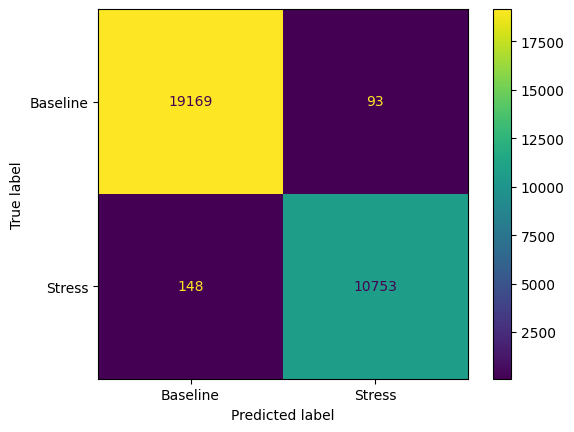

In [5]:
# Predict on test set
y_pred = (model.predict(X_test) > 0.5).astype(int)

# Print classification report
print(classification_report(y_test, y_pred))
print(f"F1 Score: {f1_score(y_test, y_pred):.3f}")

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Baseline", "Stress"]).plot()
plt.grid(False)
plt.show()


## === Plot Accuracy and Loss ===

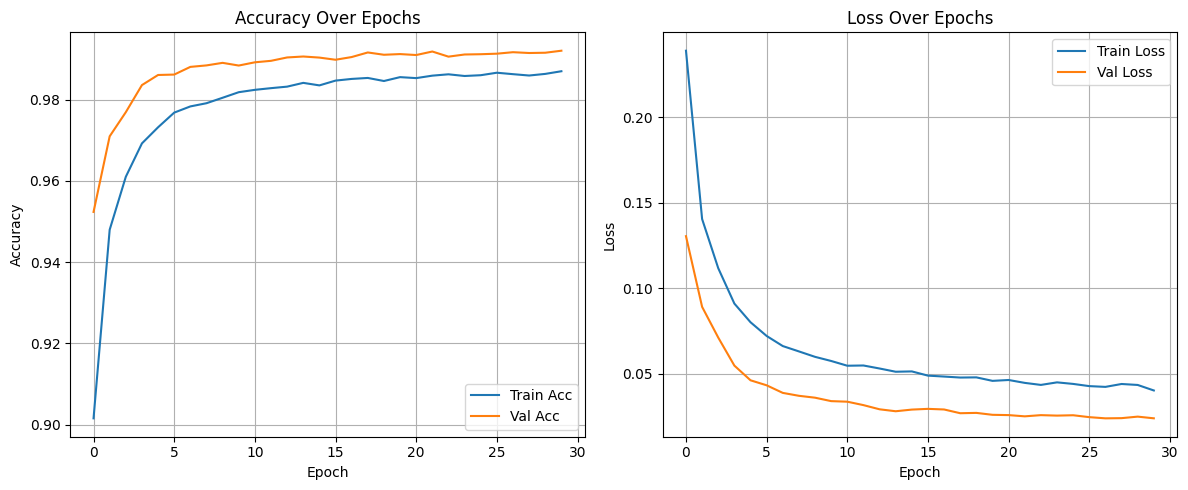

In [6]:
# Visualize training performance
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="Train Acc")
plt.plot(history.history['val_accuracy'], label="Val Acc")
plt.title("Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Val Loss")
plt.title("Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


## === Export Model to TFLite ===

In [7]:
# Save model as .tflite for mobile app
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Ensure models/ folder exists
os.makedirs("../models", exist_ok=True)

# Write .tflite model to file
with open("../models/stress_model.tflite", "wb") as f:
    f.write(tflite_model)

print("stress_model.tflite saved successfully.")


INFO:tensorflow:Assets written to: C:\Users\halab\AppData\Local\Temp\tmpag1mpnp6\assets


INFO:tensorflow:Assets written to: C:\Users\halab\AppData\Local\Temp\tmpag1mpnp6\assets


stress_model.tflite saved successfully.
